In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType

In [4]:
# Инициализация SparkSession
spark=SparkSession.builder.appName("WineQuality").getOrCreate()

In [5]:
spark

In [8]:
df = spark.read.csv('winequality-red.csv')
df.head()

Row(_c0='"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"')

In [9]:
# Cхема для df на основе структуры 
schema = StructType([
    StructField("fixed_acidity", FloatType(), True),
    StructField("volatile_acidity", FloatType(), True),
    StructField("citric_acid", FloatType(), True),
    StructField("residual_sugar", FloatType(), True),
    StructField("chlorides", FloatType(), True),
    StructField("free_sulfur_dioxide", FloatType(), True),
    StructField("total_sulfur_dioxide", FloatType(), True),
    StructField("density", FloatType(), True),
    StructField("pH", FloatType(), True),
    StructField("sulphates", FloatType(), True),
    StructField("alcohol", FloatType(), True),
    StructField("quality", IntegerType(), True)
])

In [11]:
# Загрузка данных в df PySpark, используя схему
df = spark.read.csv('winequality-red.csv', schema=schema, sep=";")
df.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|         NULL|            NULL|       NULL|          NULL|     NULL|               NULL|                NULL|   NULL|NULL|     NULL|   NULL|   NULL|
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|           

In [42]:
# Удаление строк с 'null' или 'NaN' значениями в столбце 'quality'
df = df.na.drop(subset=["quality"])

In [43]:
# анализ данных
df.describe().show(truncate=False, vertical=True)

-RECORD 0------------------------------------
 summary              | count                
 fixed_acidity        | 1599                 
 volatile_acidity     | 1599                 
 citric_acid          | 1599                 
 residual_sugar       | 1599                 
 chlorides            | 1599                 
 free_sulfur_dioxide  | 1599                 
 total_sulfur_dioxide | 1599                 
 density              | 1599                 
 pH                   | 1599                 
 sulphates            | 1599                 
 alcohol              | 1599                 
 quality              | 1599                 
-RECORD 1------------------------------------
 summary              | mean                 
 fixed_acidity        | 8.278674170104617    
 volatile_acidity     | 0.5259412126877742   
 citric_acid          | 0.2709005625675047   
 residual_sugar       | 2.296935580088393    
 chlorides            | 0.08105503419895259  
 free_sulfur_dioxide  | 15.6285178

###### Наблюдения
*нет пропусков,
*средние значения показывают различный масштаб фичей - нужно масштабирование перед обучением модели

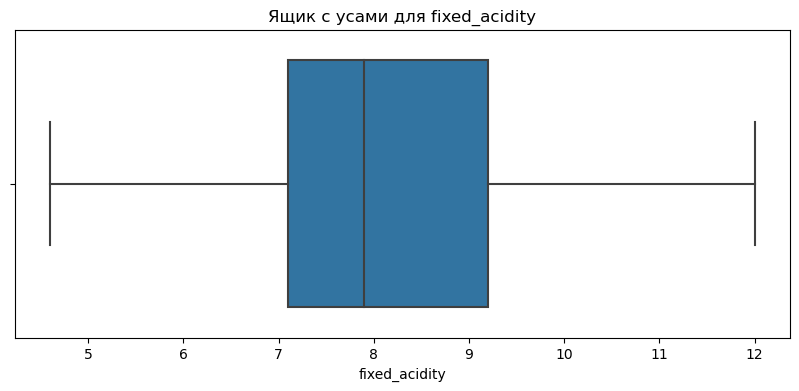

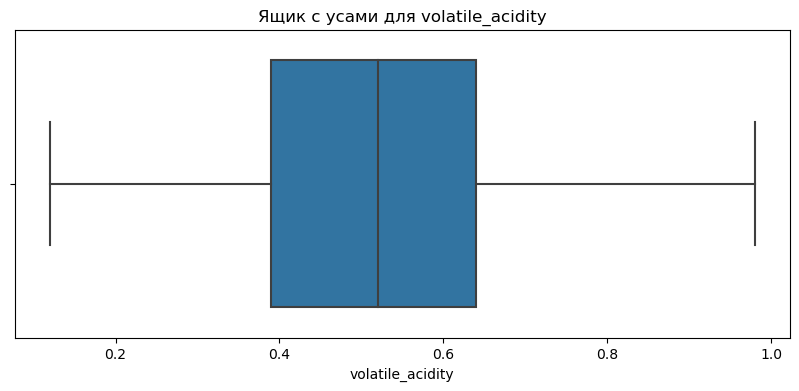

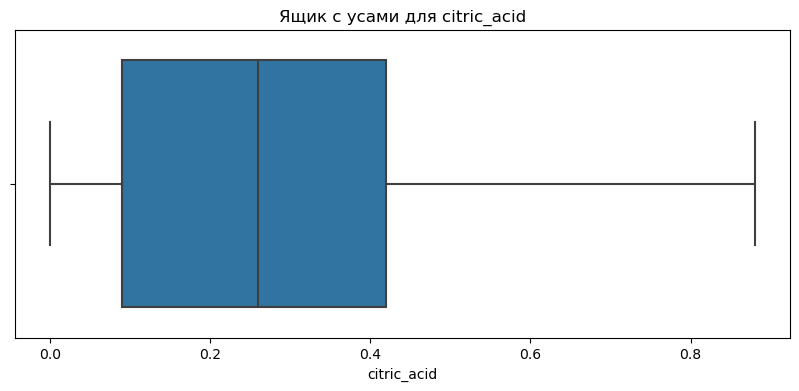

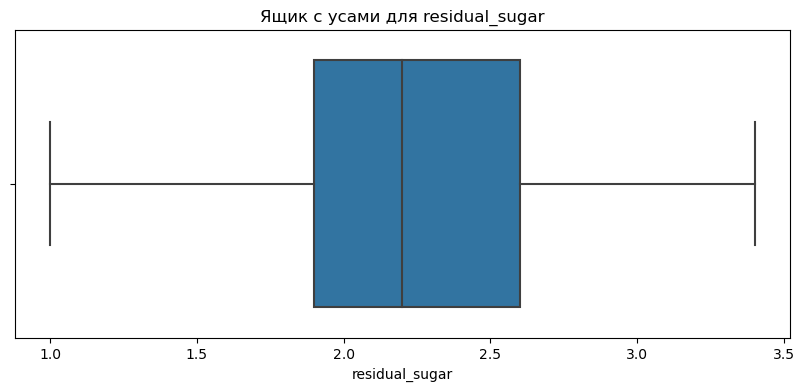

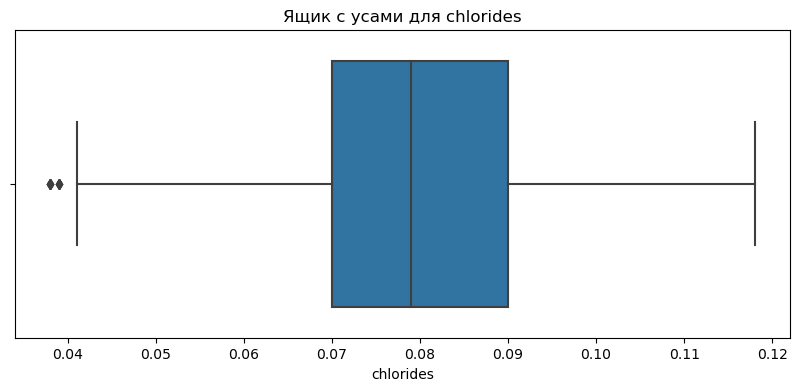

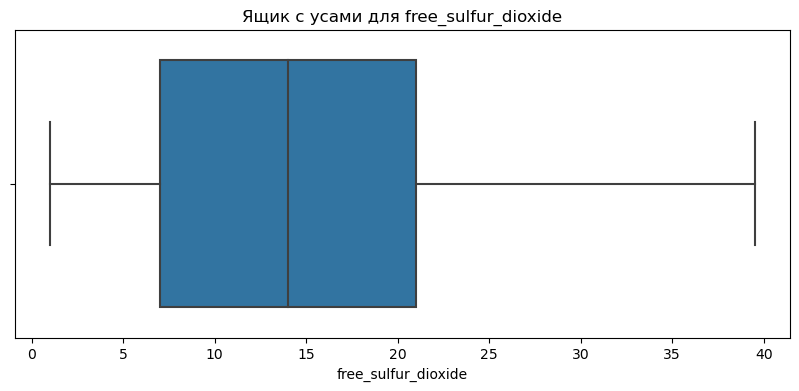

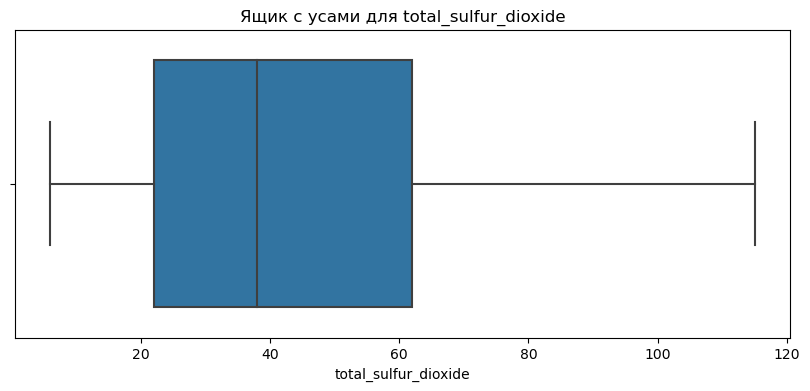

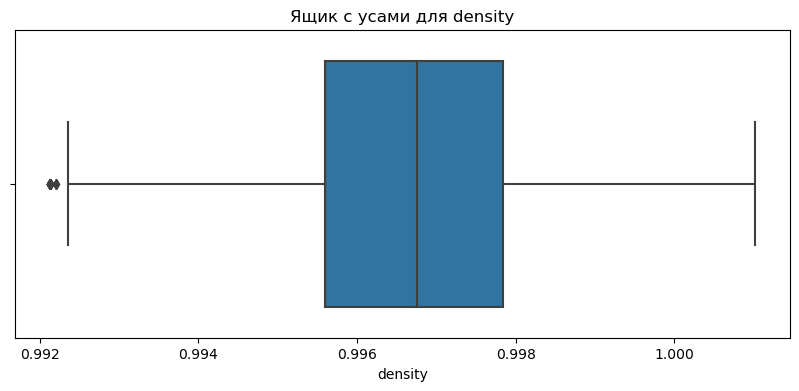

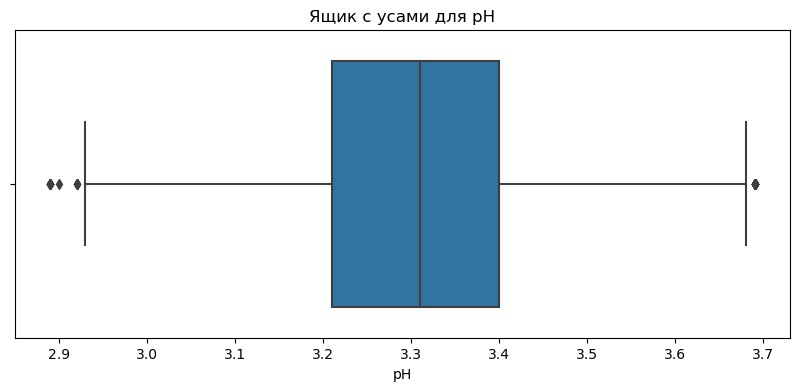

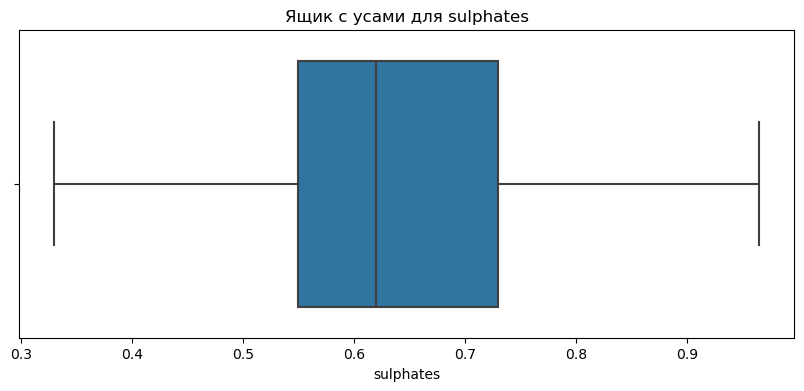

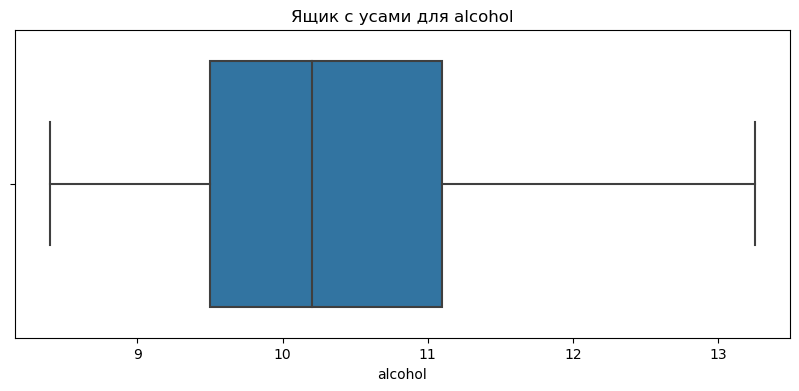

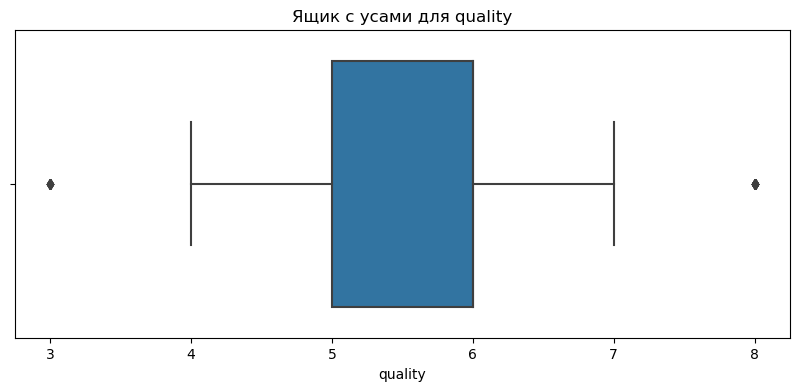

In [44]:
# оценка выбросов
import matplotlib.pyplot as plt

df_pandas = df.toPandas()

# Ящики с усами для всех фич
for column in df_pandas.columns:
    plt.figure(figsize=(10, 4))
    plt.title(f'Ящик с усами для {column}')
    sns.boxplot(x=df_pandas[column])
    plt.show()

In [45]:
from pyspark.sql.functions import col, lit, when
from pyspark.sql import DataFrame

def remove_outliers(df: DataFrame, column_name: str) -> DataFrame:
    # Вычисление квартилей и IQR
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    
    # Определение границ для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Замена выбросов на граничные значения
    df = df.withColumn(
        column_name, 
        when(col(column_name) < lit(lower_bound), lit(lower_bound))
        .when(col(column_name) > lit(upper_bound), lit(upper_bound))
        .otherwise(col(column_name))
    )
    
    return df

# Применение функции ко всем столбцам, которые нужно очистить от выбросов
columns_to_clean = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
                    'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

for column in columns_to_clean:
    df = remove_outliers(df, column)

In [46]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline

# Определение столбцов признаков (исключая целевую переменную 'quality')
feature_columns = [c for c in df.columns if c != 'quality']

# Сборка вектора признаков
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Нормализация признаков 
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Разделение данных на обучающую и тестовую выборку
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Определение модели линейной регрессии
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="quality")

# Создание конвейера
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Обучение модели
model = pipeline.fit(train_data)

# Предсказание на тестовых данных
predictions = model.transform(test_data)

In [47]:
# Оценка модели
evaluator = RegressionEvaluator(labelCol="quality", predictionCol="prediction", metricName="rmse")

# Вычисление метрик
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("R-squared on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 0.6619723118504303
R-squared on test data = 0.3749164363063864


###### Оценка качества модели 
Показатели quality варьируются от 4 до 7, что означает, что RMSE приблизительно равно 0.661, это довольно маленькая ошибка по сравнению с диапазоном целевой переменной. Однако, R-squared равный 0.3749 указывает на то, что модель не очень хорошо объясняет вариативность данных. Модель объясняет только около 37% дисперсии, что не является высоким показателем.

In [52]:
# Пробую улучшить модель. Рассмотрю важность признаков с помощью модели случайного леса 

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Сборка вектора признаков
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Определение модели случайного леса
rf = RandomForestRegressor(featuresCol="features", labelCol="quality")

# Создание конвейера
pipeline = Pipeline(stages=[assembler, rf])

# Разделение данных на обучающую и тестовую выборку
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Обучение модели
model = pipeline.fit(train_data)

# Получение обученной модели случайного леса из конвейера
rfModel = model.stages[-1]

# Вывод важности признаков
importances = rfModel.featureImportances
features = feature_columns

# Сортировка признаков по важности
sorted_features = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: alcohol, Importance: 0.361793949020417
Feature: sulphates, Importance: 0.21175371942820803
Feature: volatile_acidity, Importance: 0.14469005049405634
Feature: total_sulfur_dioxide, Importance: 0.06118851227248677
Feature: density, Importance: 0.049339032782902977
Feature: citric_acid, Importance: 0.04195729914011859
Feature: fixed_acidity, Importance: 0.038818560472865624
Feature: chlorides, Importance: 0.03274364937050089
Feature: pH, Importance: 0.02403715519263584
Feature: free_sulfur_dioxide, Importance: 0.021471617590041
Feature: residual_sugar, Importance: 0.012206454235766951


###### Free Sulfur Dioxide, Residual Sugar
Эти признаки имеют наименьшую важность среди рассмотренных, это может указывать на их ограниченное влияние на качество вина в данной модели

In [53]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Обновленный список признаков без "free_sulfur_dioxide" и "residual_sugar"
feature_columns_updated = [c for c in df.columns if c not in ('quality', 'free_sulfur_dioxide', 'residual_sugar')]

# Сборка вектора признаков с обновленным списком
assembler_updated = VectorAssembler(inputCols=feature_columns_updated, outputCol="features")

# Определение модели
rf = RandomForestRegressor(featuresCol="features", labelCol="quality")

# Создание конвейера с обновленным ассемблером
pipeline_updated = Pipeline(stages=[assembler_updated, rf])

# Обучение модели
model = pipeline.fit(train_data)

# Предсказание на тестовых данных
predictions = model.transform(test_data)

# Оценка модели
evaluator = RegressionEvaluator(labelCol="quality", predictionCol="prediction", metricName="rmse")

# Вычисление метрик
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("R-squared on test data =", r2)

Root Mean Squared Error (RMSE) on test data = 0.6517737712647992
R-squared on test data = 0.39402851358602364


###### Вывод по улучшенной модели
Модель стала лучше предсказывать качество вина. 
Однако, учитывая, что R-squared всё ещё далек от 1, и учитывая диапазон значений качества вина от 4 до 7 - есть пространство для дальнейших улучшений